In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os
import warnings
from itertools import product
from sklearn import linear_model

%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Полезные функции

In [2]:
# получение данных о поездках из региона по данным с заданными временными рамками.
# формат данных- таблица время\регион: число поездок
def read_region_from_data(dataDir, region, start_year, start_month, last_year, last_month, max_iterations = 50):
    month = start_month
    year = start_year

    df = pd.DataFrame()
    iter = 0
    while iter < max_iterations:  
        month_data = pd.read_csv(dataDir + '/trip_count_%d-%02d.csv' % (year, month))
        month_data.set_index(['Unnamed: 0'], inplace=True)
        
        strReg = str(region)
        df = pd.concat((df,month_data[strReg]), axis = 0)

        # Return on last month and year
        if (month == last_month and year == last_year):
            df.index.name = 'time'
            df.index = pd.to_datetime(df.index)
            df.columns = [strReg + '_count']
            return df

        # Increment month
        if (month == 12):
            month = 1
            year += 1
        else:
            month += 1
        
        iter += 1           

In [56]:
# Из-за аномалий (нулевых) для Бокса-Кокса введён сдвиг,
def inverse_shifted_boxcox(y, lmda, shift=10):
    return np.exp(y) - shift if lmda == 0 else (np.exp(np.log(lmda * y + 1) / lmbda)) - shift

def shifted_boxcox(y, shift=10):
    return stats.boxcox(y + shift)   

In [103]:
data = read_region_from_data('trips', 2119, 2016, 1, 2016, 5)

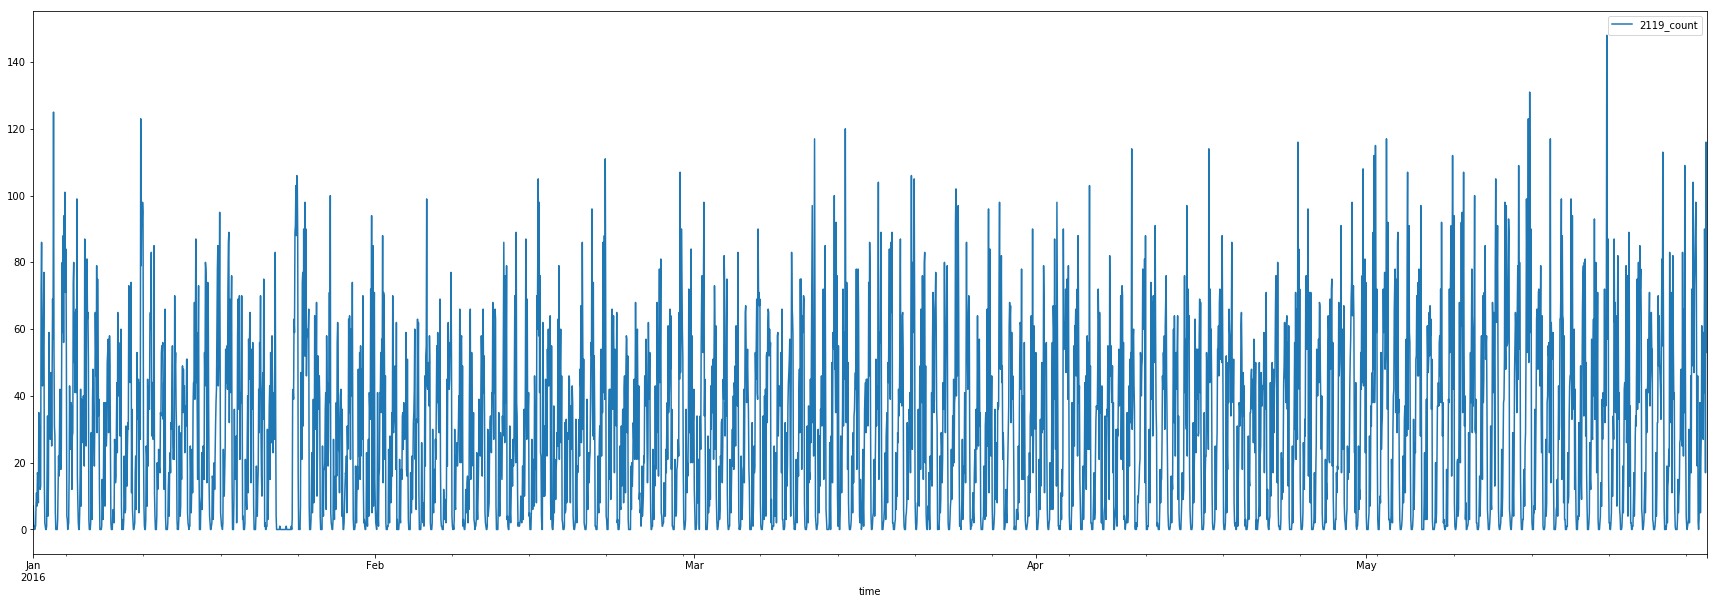

In [104]:
plt.figure(figsize(30,10))
data.plot()

Что ж, график выглядит любопытно. В глаза сразу же бросился факт нулевого числа поездок в конце первого месяца.
Возможно аномалия, может праздник, но скорее всего не работало оборудование.

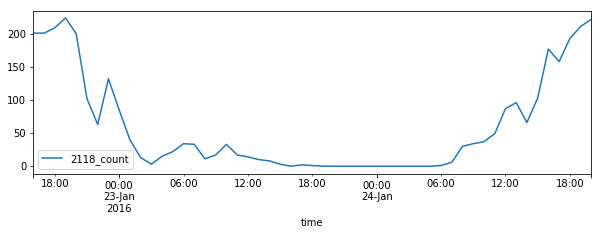

In [89]:
plt.figure(figsize(10,3))
data.ix['22-01-2016 16:00':'24-01-2016 20:00'].plot()

Получилось, что 24 января января с 18 часов вечера до 6 часов утра поездок не было (проверял по другим ячейкам, там ситуация аналогична)

Применим преобразованием Бокса-Кокса

In [105]:
column_cnt = data.columns[0]
data['boxcox'], boxcox_lambda = shifted_boxcox(data[column_cnt])
column_boxcox = data.columns[1]

In [106]:
data.head()

,2119_count,boxcox
time,,
2016-01-01 00:00:00,7.0,3.593578
2016-01-01 01:00:00,1.0,2.929023
2016-01-01 02:00:00,1.0,2.929023
2016-01-01 03:00:00,0.0,2.789659
2016-01-01 04:00:00,1.0,2.929023


Box-Cox lambda: 0.161662


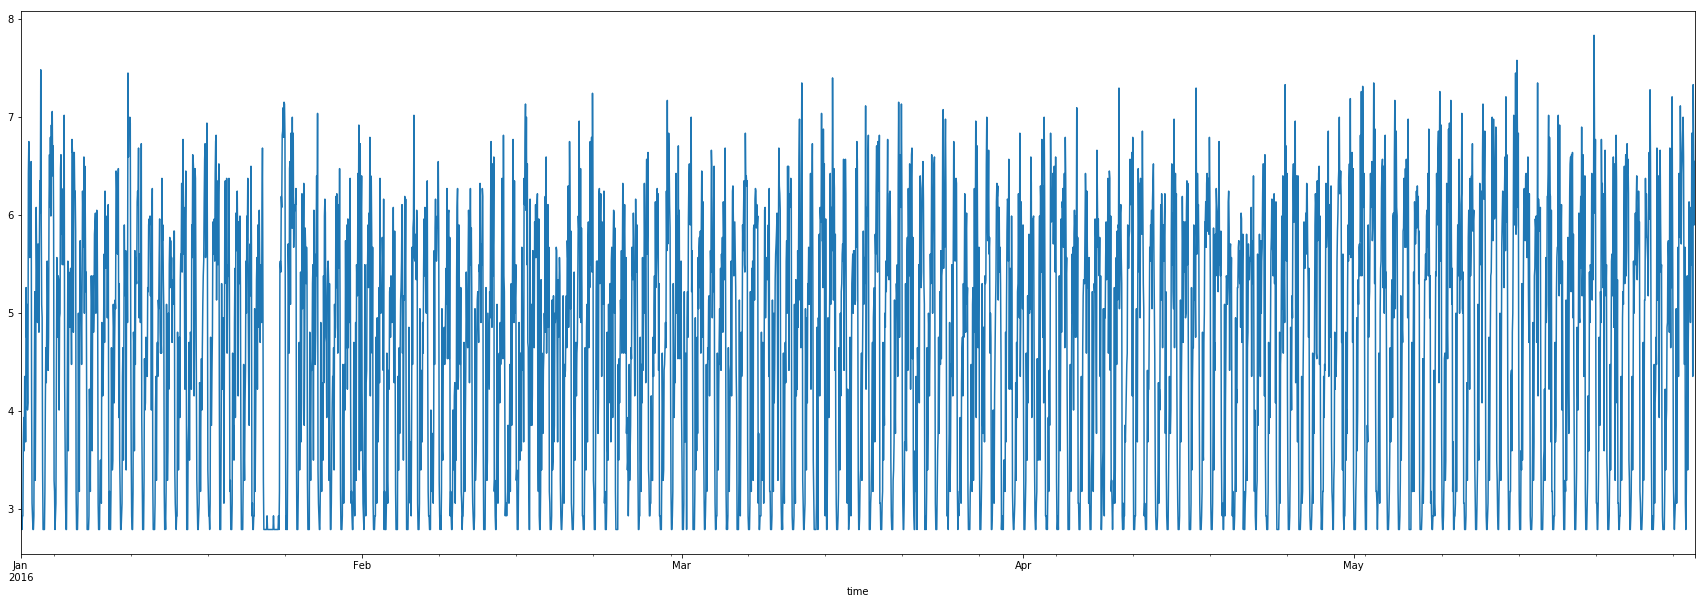

In [107]:
plt.figure(figsize(30,10))
data['boxcox'].plot()
print ("Box-Cox lambda: %f" % boxcox_lambda)

In [164]:
# для отладки
data = data.iloc[:,:2]

Перейдём к созданию регрессионных признаков.
Пробовал руками перебирать K, но это ни к чему не привело

In [165]:
K = 5
for i in range(1, K + 1):
    data['s_%d' % i] = np.fromfunction(lambda x: np.sin((x + 1) * 2 * np.pi * i / 168.0), (len(data),))
    data['c_%d' % i] = np.fromfunction(lambda x: np.cos((x + 1) * 2 * np.pi * i / 168.0), (len(data),))

Ещё можно дабавить в признаки типа дня недели, т.к в начале рабочей недели есть существенные изменения

In [166]:
for dow in range(7):
    data['dow_%d' % dow] = 0
    data.loc[data.index.dayofweek == dow, ['dow_%d' % dow]] = 1

In [167]:
# зафиксируем аномалии, тоже должно помочь
data['anomaly'] = [1 if (x < 565 and x > 530) else 0 for x in range(len(data))]

Построение Линейной регрессии

In [168]:
#1: count, 2: box-cox
lm = linear_model.LinearRegression()
X = data.iloc[:,2:]
y = data[column_boxcox]
lm.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [169]:
# считаем остатки
predictions = lm.predict(X)

resid = pd.DataFrame(index=data.index)
resid['resid'] = y - predictions

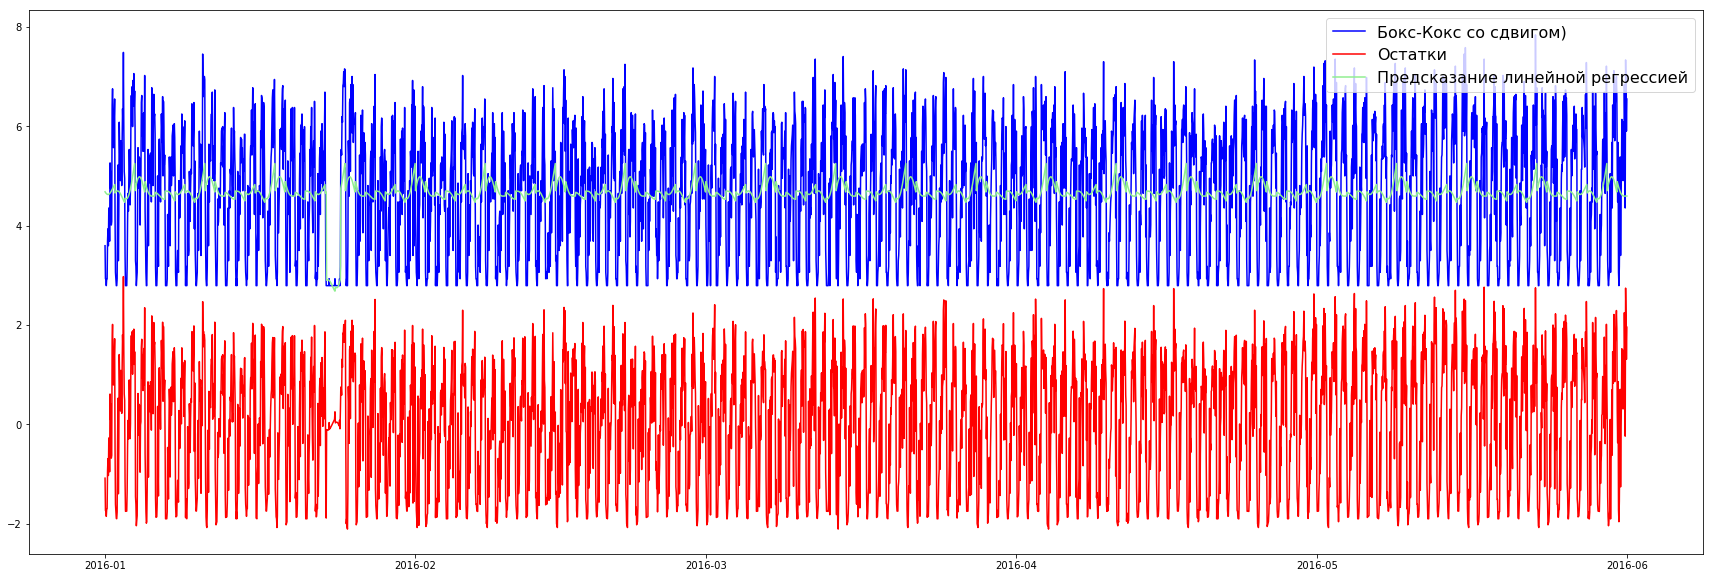

In [170]:
plt.figure(figsize(30,10))

plt.plot(data.index, data[column_boxcox].values, color='blue', label=u'Бокс-Кокс со сдвигом)')
plt.plot(data.index, resid, label=u'Остатки', color='red')
plt.plot(data.index, predictions, label=u'Предсказание линейной регрессией', color='lightgreen')
plt.legend(loc=1,prop={'size':16})

Хорошо угадывается аномальное место, но судя по всему, признаков явно не хватает, недельный тренд остаётся

Посмотрим STL декомпозицию остатков

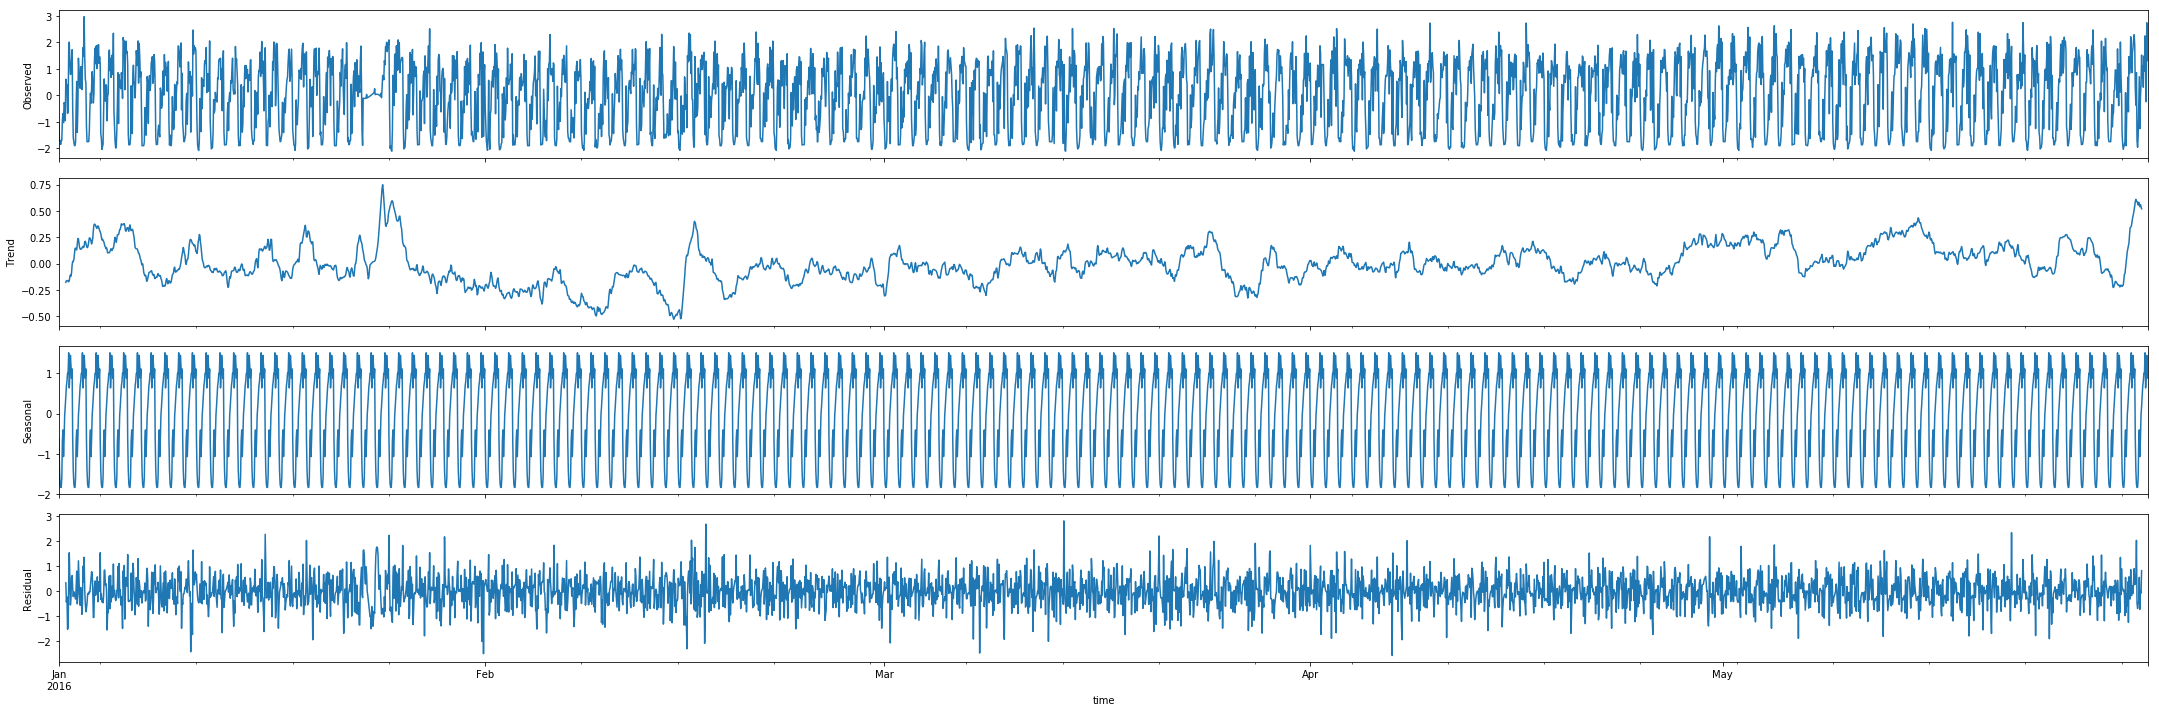

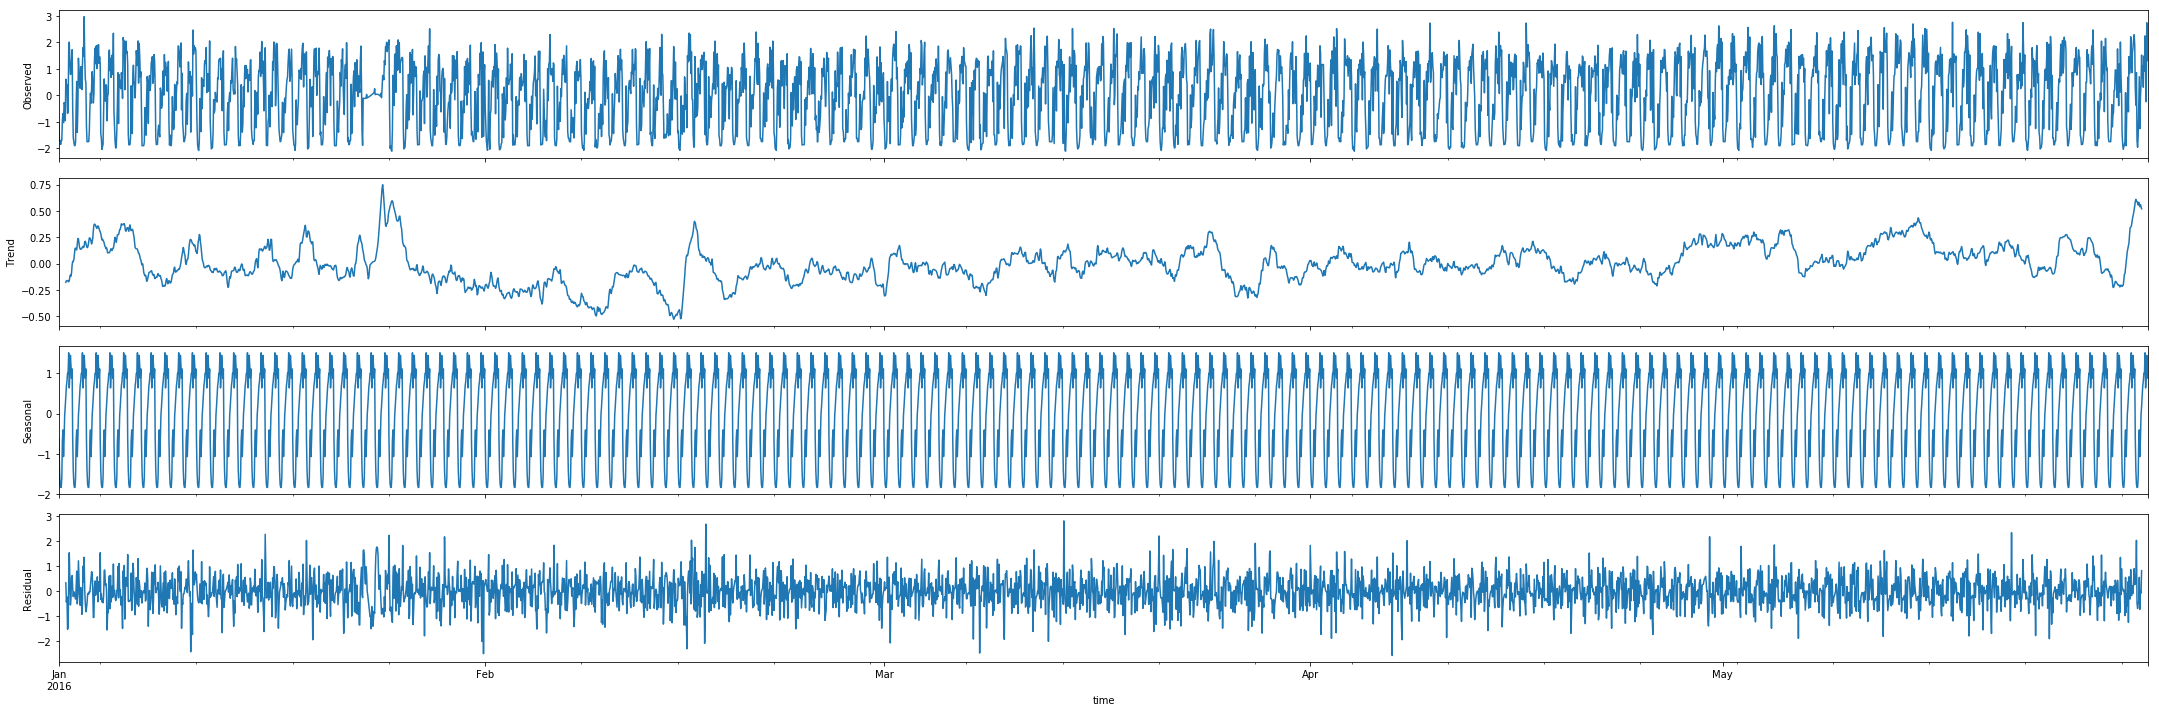

In [171]:
sm.tsa.seasonal_decompose(resid.resid).plot()

In [172]:
# введём дифференцирование на 24 часа и снова посмотрим на STL-декомпозицию.
resid['diff24'] = resid.resid - resid.resid.shift(24)

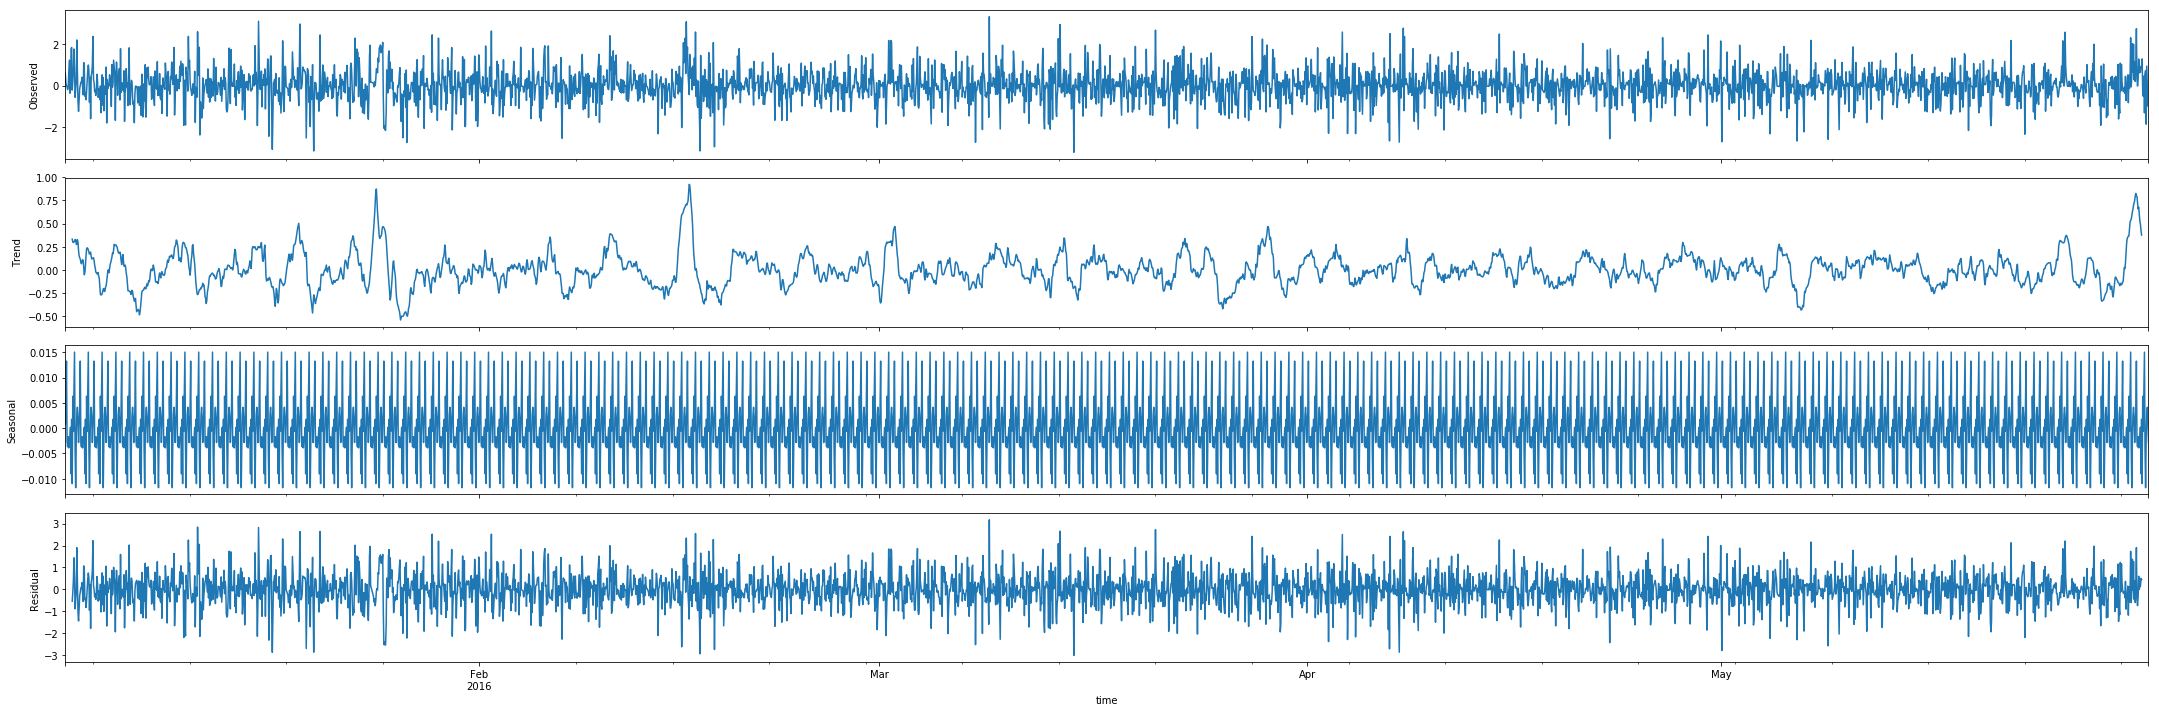

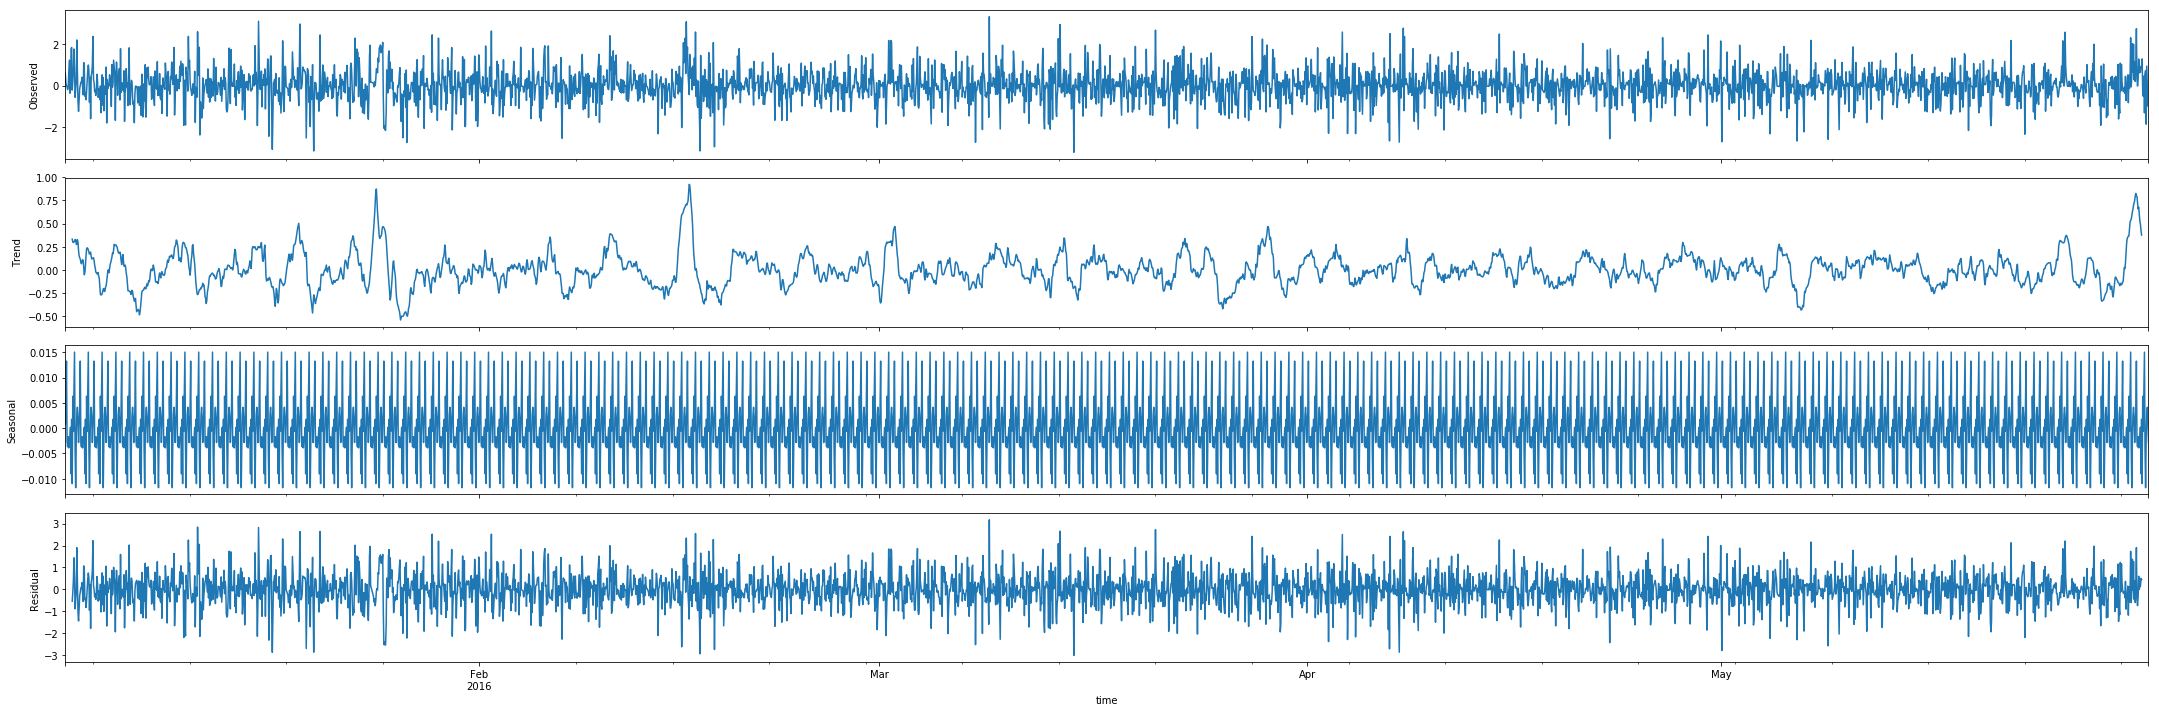

In [173]:
sm.tsa.seasonal_decompose(resid['diff24'][24:]).plot()

In [174]:
# проверим гипотезу формально
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(resid.diff24[24:])[1])

Критерий Дики-Фуллера: p=0.000000


In [175]:
def plot_acf_pacf(data, start):
    plt.figure(figsize(30,8))
    ax = plt.subplot(211)
    plt1 = sm.graphics.tsa.plot_acf(data[start:].values.squeeze(), lags=168, ax=ax)
    pylab.show()
    ax = plt.subplot(212)
    plt2 = sm.graphics.tsa.plot_pacf(data[start:].values.squeeze(), lags=168, ax=ax)
    pylab.show()

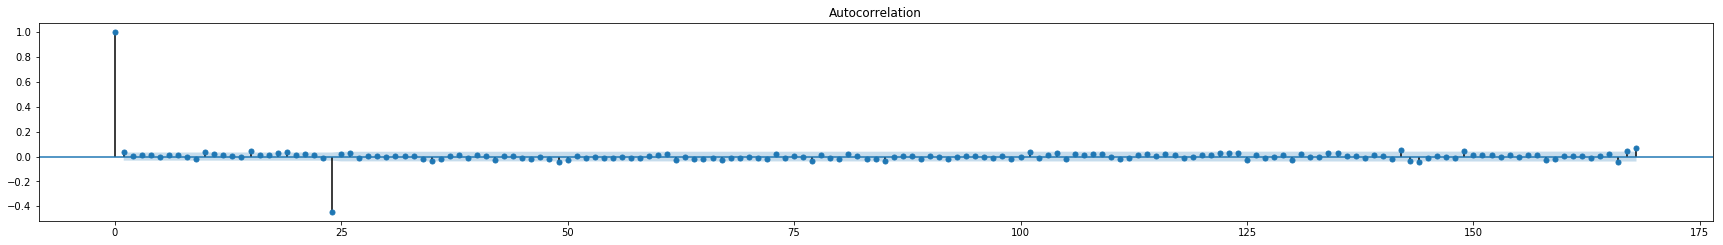

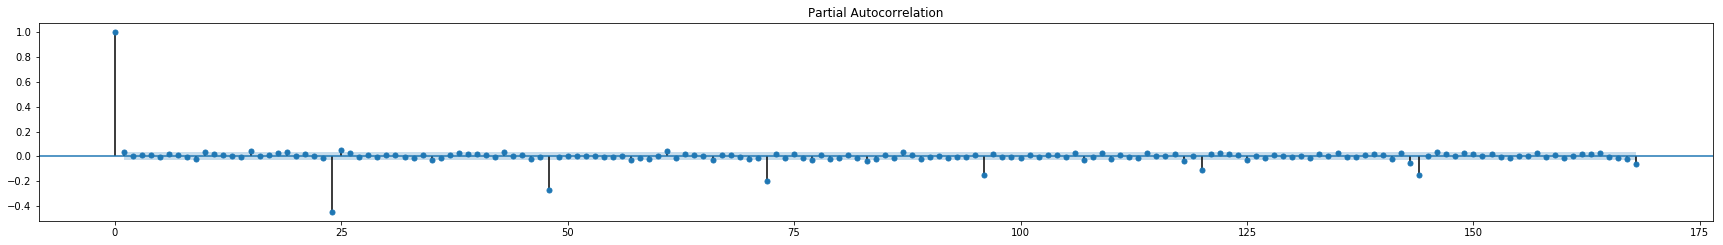

In [176]:
plot_acf_pacf(resid.diff24, 24)

Используя графики, выбираем коэффициенты для SARIMAX: Q=1, q=0, P=2, p=0 